<a href="https://colab.research.google.com/github/sruthiscodes/capstone/blob/residual/working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Feature extraction and preprocessing

In [ ]:
!pip install mne
!pip install pywavelets
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
import pywt
import pandas as pd
import os
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [ ]:
np.random.seed(42)
subjects = range(1,6)
runs = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

#preprocessing parameters
samplingFreq = 160
lowFreq = 0.5
highFreq = 45
notchFreq = 60
tMin, tMax = 0, 4

In [ ]:
"""def loadEEG(subject, runs):
  filePaths = eegbci.load_data(subject, runs)
  print(f"Loading data for subject {subject}")
  rawlist = []

  for file in filePaths:
    raw = read_raw_edf(file, preload=True)
    rawlist.append(raw)

  if len(rawlist) > 1:
    raw = mne.concatenate_raws(rawlist)
  else:
    raw = rawlist[0]

  rename_dict = {
        'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
        'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
        'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
        'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
        'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
        'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
        'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
        'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
    }
  raw.rename_channels(rename_dict)

  montage = mne.channels.make_standard_montage('standard_1020')
  raw.set_montage(montage)

  events, eventID = mne.events_from_annotations(raw)
  raw.filter(l_freq = lowFreq, h_freq = highFreq)
  raw.notch_filter(freqs = notchFreq)

  eventID = dict(T1 = 1, T2 = 2)
  epochs = mne.Epochs(raw, events, eventID, tmin=tMin, tmax=tMax, baseline=None, preload=True)
  return raw, epochs, events, eventID"""

'def loadEEG(subject, runs):\n  filePaths = eegbci.load_data(subject, runs)\n  print(f"Loading data for subject {subject}")\n  rawlist = []\n\n  for file in filePaths:\n    raw = read_raw_edf(file, preload=True)\n    rawlist.append(raw)\n\n  if len(rawlist) > 1:\n    raw = mne.concatenate_raws(rawlist)\n  else:\n    raw = rawlist[0]\n\n  rename_dict = {\n        \'Fc5.\': \'FC5\', \'Fc3.\': \'FC3\', \'Fc1.\': \'FC1\', \'Fcz.\': \'FCz\', \'Fc2.\': \'FC2\', \'Fc4.\': \'FC4\', \'Fc6.\': \'FC6\',\n        \'C5..\': \'C5\', \'C3..\': \'C3\', \'C1..\': \'C1\', \'Cz..\': \'Cz\', \'C2..\': \'C2\', \'C4..\': \'C4\', \'C6..\': \'C6\',\n        \'Cp5.\': \'CP5\', \'Cp3.\': \'CP3\', \'Cp1.\': \'CP1\', \'Cpz.\': \'CPz\', \'Cp2.\': \'CP2\', \'Cp4.\': \'CP4\', \'Cp6.\': \'CP6\',\n        \'Fp1.\': \'Fp1\', \'Fpz.\': \'Fpz\', \'Fp2.\': \'Fp2\', \'Af7.\': \'AF7\', \'Af3.\': \'AF3\', \'Afz.\': \'AFz\', \'Af4.\': \'AF4\', \'Af8.\': \'AF8\',\n        \'F7..\': \'F7\', \'F5..\': \'F5\', \'F3..\': \'F3\', \

In [ ]:
#not run

def loadEEG_for_subject(subject, runs):
    """
    Process each EDF file (run) separately so that we can remap labels based on run.
    Returns:
        combined_data: (n_epochs, n_channels, n_times)
        combined_labels: (n_epochs,)
    """
    filePaths = eegbci.load_data(subject, runs)
    print(f"Loading data for subject {subject}")

    all_epochs = []   # list to accumulate epoch data arrays
    all_labels = []   # list to accumulate remapped labels

    # Process each file independently
    for file in filePaths:
        # Extract run number from filename
        try:
            # Extract just the numeric part and convert to int
            run_str = str(file).split('R')[1].split('.')[0]
            run_number = int(run_str)
            print(f"Processing run {run_number} from file {file}")
        except Exception as e:
            print(f"Could not extract run number from {file}: {e}")
            continue

        # Load the raw EDF file
        raw = read_raw_edf(file, preload=True)

        # Rename channels as before
        rename_dict = {
            'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
            'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
            'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
            'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
            'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
            'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
            'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
            'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
        }
        raw.rename_channels(rename_dict)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # Apply filtering and notch filter
        raw.filter(l_freq=lowFreq, h_freq=highFreq, n_jobs=-1)
        raw.notch_filter(freqs=notchFreq, n_jobs=-1)

        # Create events from annotations using only T1 and T2
        events, _ = mne.events_from_annotations(raw)
        # Define event IDs for T1 and T2 (we ignore T0)
        eventID = dict(T1=1, T2=2)
        # Create epochs for this file/run
        epochs = mne.Epochs(raw, events, eventID, tmin=tMin, tmax=tMax, baseline=None, preload=True)

        data = epochs.get_data()  # (n_epochs, n_channels, n_times)
        orig_labels = epochs.events[:, -1]  # These will be 1 (T1) or 2 (T2)

        # Remap labels based on run number
        # Group 1: runs 3, 4, 7, 8, 11, 12 → Left vs Right hand
        #     T1: left hand (label 0), T2: right hand (label 1)
        # Group 2: runs 5, 6, 9, 10, 13, 14 → Hands vs Feet
        #     T1: hands (label 2), T2: feet (label 3)
        if run_number in [3, 4, 7, 8, 11, 12]:
            new_labels = [0 if lab == 1 else 1 for lab in orig_labels]
            print(f"Run {run_number}: Left vs Right hand paradigm, found {len(new_labels)} events")
        elif run_number in [5, 6, 9, 10, 13, 14]:
            new_labels = [2 if lab == 1 else 3 for lab in orig_labels]
            print(f"Run {run_number}: Hands vs Feet paradigm, found {len(new_labels)} events")
        else:
            print(f"Run {run_number} not in defined groups, skipping.")
            continue

        # Append each epoch and corresponding new label
        for i in range(len(epochs)):
            all_epochs.append(data[i])
            all_labels.append(new_labels[i])

    if len(all_epochs) == 0:
        raise ValueError(f"No epochs found for subject {subject}.")

    combined_data = np.array(all_epochs)  # shape: (n_total_epochs, n_channels, n_times)
    combined_labels = np.array(all_labels)  # shape: (n_total_epochs,)
    print(f"Subject {subject}: {combined_data.shape[0]} epochs loaded.")
    return combined_data, combined_labels

In [ ]:
#not run

def cwt_transform(signal, scales, wavelet='morl'):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)
    return coeffs

In [ ]:
#not run

def extractFeatures_from_epochs(epoch_data, labels, scales):
    """
    Process a 3D array of epochs (n_epochs, n_channels, n_times) and remap to features.
    For each channel in each epoch, compute CWT, then extract mean and std across scales.
    """
    X = []
    y = []

    print("Extracting features from epochs")
    for i, epoch in enumerate(epoch_data):
        epoch_features = []
        for channel in epoch:
            # Apply CWT to the channel signal
            coeffs = cwt_transform(channel, scales)
            # Compute statistics from CWT coefficients
            mean_coeffs = np.mean(coeffs, axis=1)
            std_coeffs = np.std(coeffs, axis=1)
            channel_features = np.concatenate([mean_coeffs, std_coeffs])
            epoch_features.append(channel_features)
        # Flatten features from all channels into a single vector
        epoch_features = np.concatenate(epoch_features)
        X.append(epoch_features)
        y.append(labels[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
#not run

allFeatures = []
allLabels = []
for subject in subjects:
    try:
        epochs_data, labels = loadEEG_for_subject(subject, runs)
        scales = np.arange(1, 128)
        # Extract features for the subject
        X_subj, y_subj = extractFeatures_from_epochs(epochs_data, labels, scales)
        allFeatures.append(X_subj)
        allLabels.append(y_subj)
    except Exception as e:
        print(f"Error processing subject {subject}: {e}")
        continue

Error processing subject 1: name 'loadEEG_for_subject' is not defined
Error processing subject 2: name 'loadEEG_for_subject' is not defined
Error processing subject 3: name 'loadEEG_for_subject' is not defined
Error processing subject 4: name 'loadEEG_for_subject' is not defined
Error processing subject 5: name 'loadEEG_for_subject' is not defined


In [ ]:
#not run

if len(allFeatures) > 0:
    X = np.vstack(allFeatures)
    y = np.concatenate(allLabels)
else:
    X = np.array([])
    y = np.array([])


In [ ]:
#not run

if not os.path.exists('./eeg_data'):
    os.makedirs('./eeg_data')
    print("Created directory: ./eeg_data")

X = np.vstack(allFeatures) if allFeatures else np.array([])
y = np.concatenate(allLabels) if allLabels else np.array([])

if X.size > 0 and y.size > 0:
    if not os.path.exists('./eeg_data'):
        os.makedirs('./eeg_data')
        print("Created directory: ./eeg_data")
    np.save('./eeg_data/X_cwt.npy', X)
    np.save('./eeg_data/y_cwt.npy', y)
    print("Saved features to ./eeg_data/X_cwt.npy")
    print("Saved labels to ./eeg_data/y_cwt.npy")
else:
    print("No features or labels to save. Check feature extraction.")

print("\nProcessing complete!")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

if y.size > 0:
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Unique labels: {unique_labels}")
    print(f"Label counts: {counts}")
    plt.figure(figsize=(8, 5))
    plt.bar(['Class '+str(c) for c in unique_labels], counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.savefig('./eeg_data/class_distribution.png')
    plt.show()

Created directory: ./eeg_data
No features or labels to save. Check feature extraction.

Processing complete!
Features shape: (0,)
Labels shape: (0,)


In [ ]:
#not run

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
unique_labels_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)
print(f"Unique labels after SMOTE: {unique_labels_resampled}")
print(f"Label counts after SMOTE: {counts_resampled}")
np.save('./eeg_data/X_resampled.npy', X_resampled)
np.save('./eeg_data/y_resampled.npy', y_resampled)

plt.figure(figsize=(8, 5))
plt.bar(['Class '+str(c) for c in unique_labels_resampled], counts_resampled)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('./eeg_data/resampled_class_distribution.png')
plt.show()

loading preloaded data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change to your directory containing the .npy files
%cd /content/drive/MyDrive/capstone
print("INSIDE CAPSTONE FOLDER")


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the .npy files directly
X_resampled = np.load('X_resampled (1).npy')
y_resampled = np.load('y_resampled (1).npy')

# Make sure classes start from 0 instead of 1 if needed
if np.min(y_resampled) == 1:
    y_resampled = y_resampled - 1

# Print shapes to verify data
print(f"X_resampled shape: {X_resampled.shape}")
print(f"y_resampled shape: {y_resampled.shape}")

# Reshape the data for 3D CNN if needed
# This will depend on your original data format
# Assuming X_resampled is (n_samples, n_features) where features are flattened
# For a 3D CNN with shape (samples, channels, time, height, width)
num_channels = 64  # Typical EEG channels
time_steps = 641   # Number of time points

# Reshape to match expected input (batch, channels, time, height, width)
print("X_resampled original shape:", X_resampled.shape)
X_reshaped = X_resampled.reshape(X_resampled.shape[0], X_resampled.shape[1], 1, 1, 1)
print(f"X_reshaped shape: {X_reshaped.shape}")

# Convert labels to categorical (One-Hot Encoding)
y_categorical = to_categorical(y_resampled)
print(f"y_categorical shape: {y_categorical.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/capstone
INSIDE CAPSTONE FOLDER
X_resampled shape: (5400, 16256)
y_resampled shape: (5400,)
X_resampled original shape: (5400, 16256)
X_reshaped shape: (5400, 16256, 1, 1, 1)
y_categorical shape: (5400, 4)


In [ ]:
num_channels = 2          # e.g., Left Hand vs Right Hand EEG channels
freq_bins = 64            # Number of frequency bins in your CWT
time_bins = 127           # Number of time bins in your CWT

# Now calculate total features
total_features = num_channels * freq_bins * time_bins
print(total_features)  # should print 16256

16256


Features: 16256, Channels: 64, Time steps: 254
X_reshaped shape: (5400, 64, 254, 1, 1)
y_categorical shape: (5400, 4)
Train shapes: (4320, 64, 254, 1, 1), (4320, 4)
Validation shapes: (1080, 64, 254, 1, 1), (1080, 4)
Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2738 - loss: 2.1338
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 268ms/step - accuracy: 0.2738 - loss: 2.1330 - val_accuracy: 0.2500 - val_loss: 1.5747 - learning_rate: 5.0000e-04
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3112 - loss: 1.7600
Epoch 2: val_accuracy did not improve from 0.25000
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.3112 - loss: 1.7600 - val_accuracy: 0.2500 - val_loss: 1.6330 - learning_rate: 5.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3361 - loss: 1.6222
Epoch 3: val_accuracy improved from 0.25000 to 0.27963, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 43s 243ms/step - accuracy: 0.3361 - loss: 1.6220 - val_accuracy: 0.2796 - val_loss: 1.6915 - learning_rate: 5.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3345 - loss: 1.6001
Epoch 4: val_accuracy improved from 0.27963 to 0.32870, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.3346 - loss: 1.5999 - val_accuracy: 0.3287 - val_loss: 1.4438 - learning_rate: 5.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3963 - loss: 1.4138
Epoch 5: val_accuracy improved from 0.32870 to 0.35000, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step - accuracy: 0.3963 - loss: 1.4139 - val_accuracy: 0.3500 - val_loss: 1.3554 - learning_rate: 5.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4120 - loss: 1.3701
Epoch 6: val_accuracy improved from 0.35000 to 0.38981, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.4120 - loss: 1.3699 - val_accuracy: 0.3898 - val_loss: 1.3238 - learning_rate: 5.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4300 - loss: 1.2984
Epoch 7: val_accuracy did not improve from 0.38981
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - accuracy: 0.4300 - loss: 1.2985 - val_accuracy: 0.3898 - val_loss: 1.3616 - learning_rate: 5.0000e-04
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4403 - loss: 1.2748
Epoch 8: val_accuracy improved from 0.38981 to 0.41481, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.4403 - loss: 1.2747 - val_accuracy: 0.4148 - val_loss: 1.2899 - learning_rate: 5.0000e-04
Epoch 9/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4635 - loss: 1.2280
Epoch 9: val_accuracy did not improve from 0.41481
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.4635 - loss: 1.2278 - val_accuracy: 0.4028 - val_loss: 1.3388 - learning_rate: 5.0000e-04
Epoch 10/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5165 - loss: 1.1321
Epoch 10: val_accuracy did not improve from 0.41481
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.5164 - loss: 1.1323 - val_accuracy: 0.4009 - val_loss: 1.4295 - learning_rate: 5.0000e-04
Epoch 11/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5105 - loss: 1.1435
Epoch 11: val_accuracy improved from 0.41481 to 0.47870, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.5105 - loss: 1.1433 - val_accuracy: 0.4787 - val_loss: 1.1720 - learning_rate: 5.0000e-04
Epoch 12/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5323 - loss: 1.0738
Epoch 12: val_accuracy did not improve from 0.47870
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - accuracy: 0.5323 - loss: 1.0737 - val_accuracy: 0.4556 - val_loss: 1.3200 - learning_rate: 5.0000e-04
Epoch 13/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5678 - loss: 1.0326
Epoch 13: val_accuracy did not improve from 0.47870
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.5678 - loss: 1.0326 - val_accuracy: 0.4093 - val_loss: 1.7442 - learning_rate: 5.0000e-04
Epoch 14/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5699 - loss: 1.0159
Epoch 14: val_accuracy improved from 0.47870 to 0.48981, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.5700 - loss: 1.0158 - val_accuracy: 0.4898 - val_loss: 1.2889 - learning_rate: 5.0000e-04
Epoch 15/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5951 - loss: 0.9628
Epoch 15: val_accuracy improved from 0.48981 to 0.54537, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.5951 - loss: 0.9628 - val_accuracy: 0.5454 - val_loss: 1.0417 - learning_rate: 5.0000e-04
Epoch 16/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6100 - loss: 0.9145
Epoch 16: val_accuracy improved from 0.54537 to 0.55463, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.6100 - loss: 0.9147 - val_accuracy: 0.5546 - val_loss: 1.0654 - learning_rate: 5.0000e-04
Epoch 17/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6353 - loss: 0.8741
Epoch 17: val_accuracy did not improve from 0.55463
135/135 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - accuracy: 0.6353 - loss: 0.8742 - val_accuracy: 0.4769 - val_loss: 1.4609 - learning_rate: 5.0000e-04
Epoch 18/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6515 - loss: 0.8599
Epoch 18: val_accuracy did not improve from 0.55463
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.6514 - loss: 0.8600 - val_accuracy: 0.5231 - val_loss: 1.2785 - learning_rate: 5.0000e-04
Epoch 19/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6640 - loss: 0.8018
Epoch 19: val_accuracy did not improve from 0.55463
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.6639 - loss: 0.8020 - val_accuracy: 0.4509 - val_loss: 1.7628 - learning_ra

135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step - accuracy: 0.6765 - loss: 0.7949 - val_accuracy: 0.5620 - val_loss: 1.0831 - learning_rate: 5.0000e-04
Epoch 21/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7032 - loss: 0.7332
Epoch 21: val_accuracy improved from 0.56204 to 0.57500, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.7033 - loss: 0.7331 - val_accuracy: 0.5750 - val_loss: 1.0687 - learning_rate: 1.0000e-04
Epoch 22/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7234 - loss: 0.6756
Epoch 22: val_accuracy did not improve from 0.57500
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - accuracy: 0.7234 - loss: 0.6756 - val_accuracy: 0.5509 - val_loss: 1.2345 - learning_rate: 1.0000e-04
Epoch 23/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7325 - loss: 0.6567
Epoch 23: val_accuracy improved from 0.57500 to 0.59259, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 240ms/step - accuracy: 0.7325 - loss: 0.6567 - val_accuracy: 0.5926 - val_loss: 1.0589 - learning_rate: 1.0000e-04
Epoch 24/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7541 - loss: 0.6252
Epoch 24: val_accuracy improved from 0.59259 to 0.61852, saving model to best_eeg_model.h5


135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - accuracy: 0.7540 - loss: 0.6253 - val_accuracy: 0.6185 - val_loss: 0.9796 - learning_rate: 1.0000e-04
Epoch 25/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7426 - loss: 0.6220
Epoch 25: val_accuracy did not improve from 0.61852
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.7426 - loss: 0.6221 - val_accuracy: 0.5898 - val_loss: 1.0863 - learning_rate: 1.0000e-04
Epoch 26/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7687 - loss: 0.5865
Epoch 26: val_accuracy did not improve from 0.61852
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.7687 - loss: 0.5866 - val_accuracy: 0.6120 - val_loss: 1.0699 - learning_rate: 1.0000e-04
Epoch 27/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7739 - loss: 0.5748
Epoch 27: val_accuracy did not improve from 0.61852
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 231ms/step - accuracy: 0.7739 - loss: 0.5748 - val_accuracy: 0.6157 - val_loss: 1.0885 - learning_ra

135/135 ━━━━━━━━━━━━━━━━━━━━ 43s 243ms/step - accuracy: 0.8020 - loss: 0.5090 - val_accuracy: 0.6306 - val_loss: 1.0360 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 30.
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6231 - loss: 1.0384
Validation Accuracy: 63.06%


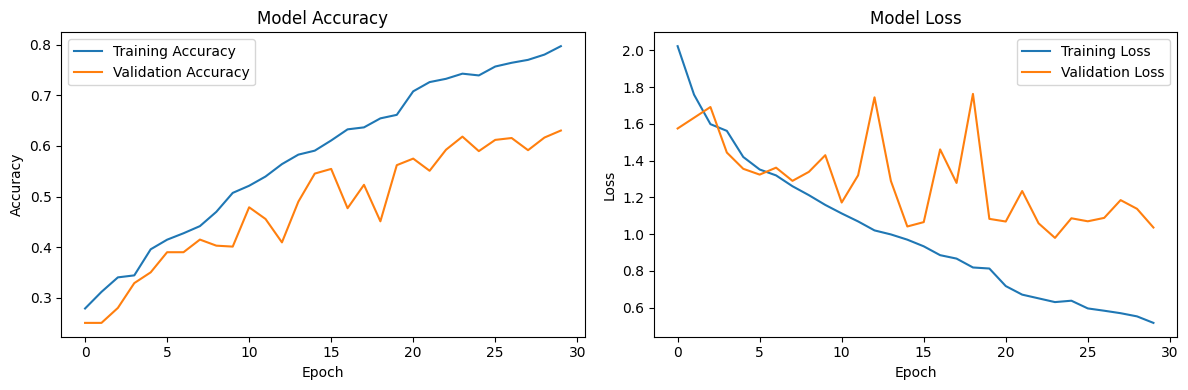

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
Confusion Matrix:
[[101  59  50  60]
 [  9 218   3  40]
 [ 46  22 118  84]
 [  2   8  16 244]]


<Figure size 1000x800 with 0 Axes>

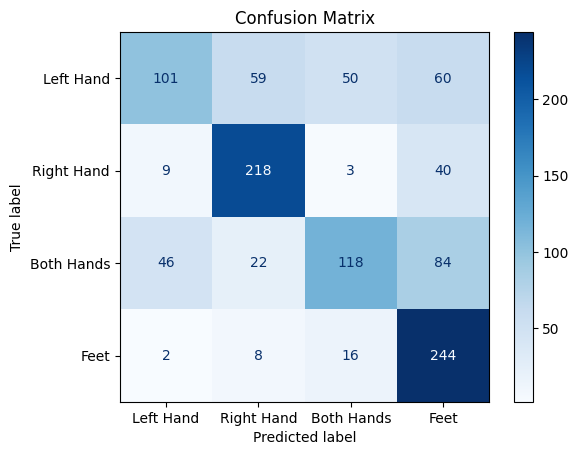


Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.64      0.37      0.47       270
  Right Hand       0.71      0.81      0.76       270
  Both Hands       0.63      0.44      0.52       270
        Feet       0.57      0.90      0.70       270

    accuracy                           0.63      1080
   macro avg       0.64      0.63      0.61      1080
weighted avg       0.64      0.63      0.61      1080

Model saved as 'eeg_classifier_improved.h5'


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, Dense, Dropout, Flatten, Add, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
X_resampled = np.load('X_resampled (1).npy')
y_resampled = np.load('y_resampled (1).npy')

# Make sure classes start from 0 instead of 1 if needed
if np.min(y_resampled) == 1:
    y_resampled = y_resampled - 1

# Get dimensions
n_samples, n_features = X_resampled.shape
num_channels = 64
time_steps = n_features // num_channels
print(f"Features: {n_features}, Channels: {num_channels}, Time steps: {time_steps}")

# Normalize data - critical for performance
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_resampled)

# Reshape to 3D CNN format (samples, channels, time_steps, 1, 1)
X_reshaped = X_normalized.reshape(n_samples, num_channels, time_steps, 1, 1)
print(f"X_reshaped shape: {X_reshaped.shape}")

# One-hot encode labels
y_categorical = to_categorical(y_resampled)
print(f"y_categorical shape: {y_categorical.shape}")

# Split data properly - use dedicated validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y_categorical, test_size=0.2, random_state=42, stratify=y_resampled
)
print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {y_val.shape}")

# Create a ResNet-style block for better performance
def residual_block(x, filters, kernel_size=(3, 3, 1)):
    shortcut = x

    # First conv layer
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second conv layer
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut
    if shortcut.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Build improved model with residual connections
input_layer = Input(shape=(num_channels, time_steps, 1, 1))

# First block
x = Conv3D(64, (3, 3, 1), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 1))(x)

# Residual blocks
x = residual_block(x, 64)
x = MaxPooling3D((2, 2, 1))(x)
x = Dropout(0.3)(x)

x = residual_block(x, 128)
x = MaxPooling3D((2, 2, 1))(x)
x = Dropout(0.4)(x)

x = residual_block(x, 256)
x = MaxPooling3D((2, 2, 1))(x)
x = Dropout(0.4)(x)

# Classification head
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(y_categorical.shape[1], activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Use callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when plateauing
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    # Save best model
    ModelCheckpoint(
        'best_eeg_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train with proper validation data and callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # More epochs with early stopping
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('improved_training_history.png')
plt.show()

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Class names for visualization
class_names = ['Left Hand', 'Right Hand', 'Both Hands', 'Feet']

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('improved_confusion_matrix.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Save the model
model.save('eeg_classifier_improved.h5')
print("Model saved as 'eeg_classifier_improved.h5'")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Add, Activation, GlobalAveragePooling3D, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, Reshape, Permute, LayerNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
X_resampled = np.load('X_resampled (1).npy')
y_resampled = np.load('y_resampled (1).npy')

# Make sure classes start from 0
if np.min(y_resampled) == 1:
    y_resampled = y_resampled - 1

# Get dimensions
n_samples, n_features = X_resampled.shape
num_channels = 64
time_steps = n_features // num_channels
print(f"Features: {n_features}, Channels: {num_channels}, Time steps: {time_steps}")

# Apply more sophisticated normalization
# Channel-wise standardization
X_normalized = np.zeros_like(X_resampled)
X_reshaped_temp = X_resampled.reshape(n_samples, num_channels, -1)
for i in range(num_channels):
    scaler = StandardScaler()
    X_normalized[:, i*time_steps:(i+1)*time_steps] = scaler.fit_transform(X_reshaped_temp[:, i, :])

# Reshape for 3D CNN
X_reshaped = X_normalized.reshape(n_samples, num_channels, time_steps, 1, 1)
print(f"X_reshaped shape: {X_reshaped.shape}")

# One-hot encode labels
y_categorical = to_categorical(y_resampled)
print(f"y_categorical shape: {y_categorical.shape}")

# Create training, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reshaped, y_categorical, test_size=0.3, random_state=42, stratify=y_resampled
)
# Further split temp data into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42
)
print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {y_val.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

# Data Augmentation Function
def augment_eeg(x, noise_factor=0.05, shift_limit=5):
    batch_size = x.shape[0]
    augmented = np.copy(x)

    # Add random noise
    noise = np.random.normal(0, noise_factor, augmented.shape)
    augmented += noise

    # Time shifting (along time dimension)
    for i in range(batch_size):
        shift = np.random.randint(-shift_limit, shift_limit)
        if shift != 0:
            # Shift along time dimension (axis 2)
            augmented[i, :, :, :, :] = np.roll(augmented[i, :, :, :, :], shift, axis=1)

    return augmented

# Generate augmented data for training
X_train_aug = augment_eeg(X_train)
X_train_combined = np.vstack([X_train, X_train_aug])
y_train_combined = np.vstack([y_train, y_train])
print(f"Augmented training set: {X_train_combined.shape}")

# Enhanced Residual Block with more regularization
def residual_block(x, filters, kernel_size=(3, 3, 1), dropout_rate=0.3, l2_reg=0.001):
    shortcut = x

    # First conv layer with L2 regularization
    x = Conv3D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Second conv layer
    x = Conv3D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    # Adjust shortcut dimensions if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Self-attention module for EEG
def attention_module(x, name):
    # Reshape for attention
    orig_shape = x.shape
    channels = orig_shape[-1]
    x_reshaped = Reshape((-1, channels))(x)

    # Self attention
    attention_output = MultiHeadAttention(
        num_heads=4, key_dim=channels, dropout=0.1, name=f"{name}_mha"
    )(x_reshaped, x_reshaped)

    # Add & norm
    x_reshaped = LayerNormalization()(x_reshaped + attention_output)

    # Reshape back
    x_out = Reshape(orig_shape[1:-1] + (channels,))(x_reshaped)
    return x_out

# Build an ensemble of two parallel paths with shared and specific components
def build_dual_path_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Shared initial layers
    x = Conv3D(64, (3, 3, 1), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((2, 2, 1))(x)

    # Path 1: Residual blocks
    path1 = residual_block(x, 64, dropout_rate=0.3)
    path1 = MaxPooling3D((2, 2, 1))(path1)

    path1 = residual_block(path1, 128, dropout_rate=0.4)
    path1 = MaxPooling3D((2, 2, 1))(path1)

    path1 = residual_block(path1, 256, dropout_rate=0.4)
    path1 = Reshape((path1.shape[1], path1.shape[2], -1))(path1)
    path1 = attention_module(path1, "path1")
    path1 = Reshape((path1.shape[1], path1.shape[2], 1, -1))(path1)
    path1 = GlobalAveragePooling3D()(path1)

    # Path 2: Deeper residual network
    path2 = residual_block(x, 64, dropout_rate=0.3)
    path2 = residual_block(path2, 64, dropout_rate=0.3)
    path2 = MaxPooling3D((2, 2, 1))(path2)

    path2 = residual_block(path2, 128, dropout_rate=0.4)
    path2 = residual_block(path2, 128, dropout_rate=0.4)
    path2 = MaxPooling3D((2, 2, 1))(path2)

    path2 = residual_block(path2, 256, dropout_rate=0.5)
    path2 = Flatten()(path2)

    # Merge paths
    merged = Concatenate()([path1, path2])

    # Classification head
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create model
model = build_dual_path_model(
    input_shape=(num_channels, time_steps, 1, 1),
    num_classes=y_categorical.shape[1]
)

# Compile with a cyclical learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=5*len(X_train_combined)//32,  # 5 epochs worth of steps
    t_mul=2.0,  # Double the cycle length each restart
    m_mul=0.9,  # Slightly decrease max lr each restart
    alpha=0.0001  # Minimum lr value
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
callbacks = [
    # Early stopping with longer patience
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when plateauing
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    # Save best model
    ModelCheckpoint(
        'best_eeg_model_advanced.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train with augmented data and callbacks
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=30,  # More epochs with early stopping
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot training history with smoother curves
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', alpha=0.3)
plt.plot(smooth_curve(history.history['accuracy']), label='Smoothed Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', alpha=0.3)
plt.plot(smooth_curve(history.history['val_accuracy']), label='Smoothed Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.3)
plt.plot(smooth_curve(history.history['loss']), label='Smoothed Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.3)
plt.plot(smooth_curve(history.history['val_loss']), label='Smoothed Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('advanced_training_history.png')
plt.show()

# Generate confusion matrix with better visualization
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Class names for visualization
class_names = ['Left Hand', 'Right Hand', 'Both Hands', 'Feet']

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Create a normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot enhanced confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('advanced_confusion_matrix.png', dpi=300)
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Save the model
model.save('eeg_classifier_advanced.h5')
print("Advanced model saved as 'eeg_classifier_advanced.h5'")

FileNotFoundError: [Errno 2] No such file or directory: 'X_resampled (1).npy'

STCNN

In [ ]:
num_samples = X_resampled.shape[0]
# For example, if we choose 64 channels:
num_channels = 64
time_steps = total_features // num_channels  # inferred time_steps from feature vector length
X_reshaped = X_resampled.reshape(num_samples, num_channels, time_steps, 1, 1)

# Standardize each channel independently
for i in range(num_channels):
    X_reshaped[:, i, :, 0, 0] = StandardScaler().fit_transform(X_reshaped[:, i, :, 0, 0])

# Convert labels to one-hot vectors.
# Note: With our new mapping, there are 4 classes.
y_categorical = to_categorical(y_resampled, num_classes=4)

# Build a basic STCNN Model.
# IMPORTANT: Since we have 4 classes, we use softmax activation at the output
# and compile with "categorical_crossentropy".
model = Sequential([
    Conv3D(32, (3, 3, 1), activation='relu', input_shape=(num_channels, time_steps, 1, 1)),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    Conv3D(64, (3, 3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    Conv3D(128, (3, 3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes: 0, 1, 2, 3
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_reshaped, y_categorical, epochs=20, batch_size=16, validation_split=0.3)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_reshaped, y_categorical)
print(f"Test Accuracy: {test_acc * 100:.2f}%")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.3008 - loss: 7.4140 - val_accuracy: 0.4368 - val_loss: 8.1348
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.3575 - loss: 1.3766 - val_accuracy: 0.1456 - val_loss: 1.6527
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.3507 - loss: 1.3431 - val_accuracy: 0.0580 - val_loss: 1.7402
Epoch 4/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.3464 - loss: 1.3504 - val_accuracy: 0.0561 - val_loss: 1.6154
Epoch 5/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.3694 - loss: 1.2894 - val_accuracy: 0.0617 - val_loss: 1.5899
Epoch 6/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.3805 - loss: 1.3001 - val_accuracy: 0.0648 - val_loss: 1.6213
Epoch 7/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.3708 - loss: 1.2817 - val_accuracy: 0.0635 - val_loss: 1.5744
Epoch 8/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.3607 - loss: 1.2773 - 

In [ ]:
# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.savefig('./eeg_data/training_vs_validation_accuracy.png')
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_reshaped), axis=1)
y_true = np.argmax(y_categorical, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('./eeg_data/confusion_matrix.png')
plt.show()

In [ ]:
model.summary()

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, BatchNormalization, MaxPooling3D, GlobalAveragePooling3D,
    Flatten, Dense, Dropout, LeakyReLU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


num_samples, total_features = X_resampled.shape
num_channels = 64  # Adjust based on EEG setup
time_steps = total_features // num_channels


# Standardize data (better normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Reshape data for 3D CNN
X_reshaped = X_scaled.reshape(num_samples, num_channels, time_steps, 1, 1)

# Convert labels to categorical (One-Hot Encoding)
y_categorical = to_categorical(y_resampled)

# Build Improved STCNN Model
model = Sequential([
    # First Conv Layer
    Conv3D(32, (3, 3, 3), padding="same", activation="relu", input_shape=(num_channels, time_steps, 1, 1)),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    # Second Conv Layer
    Conv3D(64, (3, 3, 3), padding="same",activation='relu'),

    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    # Third Conv Layer
    Conv3D(128, (3, 3, 3), padding="same",activation='relu'),

    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    # Global Average Pooling instead of Flatten
    Flatten(),

    # Fully Connected Layer
    Dense(256, activation="relu"),
    Dropout(0.5),

    # Output Layer
    Dense(y_categorical.shape[1], activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])



# Train the model
history = model.fit(
    X_reshaped, y_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.3

)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_reshaped, y_categorical)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load resampled data
X_resampled = np.load('./eeg_data/X_resampled.npy')
y_resampled = np.load('./eeg_data/y_resampled.npy')

# Reshape X_resampled to (samples, channels, time, 1)


# Convert labels to categorical
num_classes = len(np.unique(y_resampled))
y_resampled -= 1  # Convert labels from [1, 2] to [0, 1]
num_classes = len(np.unique(y_resampled))  # Recalculate
y_resampled = to_categorical(y_resampled, num_classes)



print("Final X shape:", X_resampled.shape)
print("Final y shape:", y_resampled.shape)


In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Select a signal (for example, the first channel of the first epoch)
signal = epochs.get_data()[0, 0, :]  # [epoch_idx, channel_idx, :]

# Define wavelet scales and compute CWT
scales = np.arange(1, 128)
coeffs, freqs = pywt.cwt(signal, scales, 'morl')

# Visualize CWT as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeffs), extent=[0, signal.shape[0], scales[-1], scales[0]], cmap='jet', aspect='auto')
plt.colorbar(label='Coefficient magnitude')
plt.title('CWT of First Channel, First Epoch')
plt.xlabel('Time (samples)')
plt.ylabel('Scales')
plt.savefig('./eeg_data/cwt_visualization.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

def plot_scalogram(signal, scales, wavelet='morl'):
    # Perform continuous wavelet transform
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)

    # Plot the scalogram
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coeffs), extent=[0, len(signal), scales[0], scales[-1]], cmap='jet', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.title('Scalogram (CWT) - Channel Signal')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.show()

# Select one epoch and one channel (example: first epoch, first channel)
epoch_data = epochs.get_data()[0]  # First epoch
channel_signal = epoch_data[0]  # First channel in the epoch

# Define wavelet scales
scales = np.arange(1, 128)

# Plot the scalogram for this channel
plot_scalogram(channel_signal, scales)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

# Define frequency bands (in Hz)
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 45)
}

def plot_scalogram_for_band(signal, scales, freqs, band_name, band_freqs):
    # Filter the scales corresponding to the band
    band_mask = (freqs >= band_freqs[0]) & (freqs <= band_freqs[1])
    band_coeffs = np.abs(coeffs[band_mask, :])  # Filtered wavelet coefficients
    band_scales = scales[band_mask]  # Corresponding scales for this band

    # Plot the scalogram for the given band
    plt.figure(figsize=(10, 6))
    plt.imshow(band_coeffs, extent=[0, len(signal), band_scales[0], band_scales[-1]], cmap='jet', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scalogram (CWT) - {band_name} Band ({band_freqs[0]}-{band_freqs[1]} Hz)')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.show()

# Select one epoch and one channel (example: first epoch, first channel)
epoch_data = epochs.get_data()[0]  # First epoch
channel_signal = epoch_data[0]  # First channel in the epoch

# Define wavelet scales and perform CWT
scales = np.arange(1, 128)
coeffs, freqs = pywt.cwt(channel_signal, scales, 'morl', sampling_period=1/samplingFreq)

# Plot scalograms for each frequency band
for band_name, band_freqs in freq_bands.items():
    plot_scalogram_for_band(channel_signal, scales, freqs, band_name, band_freqs)